# ICAPS24 SkDecide Tutorial: Implementing a scikit-decide domain for RDDL problems

In [1]:
!wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py

from install_skdecide import install_skdecide
install_skdecide(using_nightly_version=True, force_reinstall=False)

--2024-05-22 18:10:45--  https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2214 (2,2K) [text/plain]
Saving to: ‘install_skdecide.py.6’

install_skdecide.py 100%[===================>]   2,16K  --.-KB/s    in 0s      

2024-05-22 18:10:45 (117 MB/s) - ‘install_skdecide.py.6’ saved [2214/2214]

Scikit-decide is already installed and we should not forcely reinstall it


In [1]:
!pip --default-timeout=1000 install pyRDDLGym pyRDDLGym-rl rddlrepository

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 1.5 MB/s eta 0:00:00a 0:00:01


[Code generator](https://airbus.github.io/scikit-decide/codegen/)

## Without action preconditions

![Domain code generator](pictures/skdecide_domain_generator.png)

```python
from enum import Enum
from typing import *

from skdecide import *
from skdecide.builders.domain import *


# Example of State type (adapt to your needs)
class State(NamedTuple):
    x: int
    y: int


# Example of Action type (adapt to your needs)
class Action(Enum):
    up = 0
    down = 1
    left = 2
    right = 3


class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = State  # Type of states
    T_observation = T_state  # Type of observations
    T_event = Action  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class MyDomain(D):
    
    def _state_step(self, action: D.T_event) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        pass
    
    def _get_action_space_(self) -> Space[D.T_event]:
        pass
    
    def _state_reset(self) -> D.T_state:
        pass
    
    def _get_observation_space_(self) -> Space[D.T_observation]:
        pass

    def _render_from(self, memory: D.T_state, **kwargs: Any) -> Any:
        pass
```

In [19]:
from typing import Any
import os, shutil
from datetime import datetime as dt

from skdecide.core import TransitionOutcome, Value, Space
from skdecide.domains import RLDomain
from skdecide.builders.domain import UnrestrictedActions, FullyObservable, Renderable
from skdecide.hub.space.gym import DictSpace, GymSpace, MultiDiscreteSpace
from skdecide.utils import rollout

import pyRDDLGym
from pyRDDLGym_rl.core.env import SimplifiedActionRDDLEnv
from pyRDDLGym.core.visualizer.viz import BaseViz
from pyRDDLGym.core.visualizer.chart import ChartVisualizer

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = DictSpace  # Type of states
    T_observation = T_state  # Type of observations
    T_event = MultiDiscreteSpace  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class RDDLDomain(D):

    def __init__(self,
                 rddl_domain: str,
                 rddl_instance: str,
                 visualizer: BaseViz = ChartVisualizer,
                 movie_name: str = None,
                 max_frames=100):
        self.rddl_gym_env = pyRDDLGym.make(rddl_domain,
                                           rddl_instance,
                                           base_class=SimplifiedActionRDDLEnv,
                                           enforce_action_constraints=True)
        self.movie_name = movie_name
        if movie_name is not None:
            self.movie_path = os.path.join('rddl_movies', movie_name)
            if not os.path.exists(self.movie_path):
                os.makedirs(self.movie_path)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            if os.path.exists(tmp_pngs):
                shutil.rmtree(tmp_pngs)
            os.makedirs(tmp_pngs)
            self.movie_gen = MovieGenerator(tmp_pngs, movie_name, max_frames=max_frames)
            self.rddl_gym_env.set_visualizer(visualizer, self.movie_gen)
        else:
            self.movie_gen = None
            self.rddl_gym_env.set_visualizer(visualizer)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        next_state, reward, terminated, truncated, _ = self.rddl_gym_env.step(action)
        termination = terminated or truncated
        if termination and self.movie_gen is not None:
            self.movie_gen.save_animation(self.movie_name)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            shutil.move(os.path.join(tmp_pngs, self.movie_name + '.gif'),
                        os.path.join(self.movie_path, self.movie_name + '_' +
                                     str(dt.now().strftime("%Y%m%d-%H%M%S")) +
                                     '.gif'))
        return TransitionOutcome(
            state=next_state, value=Value(reward=reward), termination=termination
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        return GymSpace(self.rddl_gym_env.action_space)

    def _state_reset(self) -> D.T_state:
        # SkDecide only needs the state, not the info
        return self.rddl_gym_env.reset()[0]

    def _get_observation_space_(self) -> Space[D.T_observation]:
        return GymSpace(self.rddl_gym_env.observation_space)

    def _render_from(self, memory: D.T_state = None, **kwargs: Any) -> Any:
        # We do not want the image to be displayed in a pygame window, but rather in this notebook
        rddl_gym_img = self.rddl_gym_env.render(to_display=False)
        clear_output(wait=True)
        display(rddl_gym_img)

In [2]:
from rddlrepository.core.manager import RDDLRepoManager
manager = RDDLRepoManager(rebuild=True)
print(sorted(manager.list_problems()))

['AcademicAdvising_MDP_ippc2014', 'AcademicAdvising_POMDP_ippc2014', 'AcademicAdvising_ippc2018', 'Cartpole_Continuous_gym', 'Cartpole_Discrete_gym', 'ChromaticDice_ippc2018', 'ComplexSysAdmin_rddlsim', 'CooperativeRecon_MDP_ippc2011', 'CooperativeRecon_POMDP_ippc2011', 'CooperativeRecon_ippc2018', 'CrossingTraffic_MDP_ippc2011', 'CrossingTraffic_MDP_ippc2014', 'CrossingTraffic_POMDP_ippc2011', 'CrossingTraffic_POMDP_ippc2014', 'EarthObservation_ippc2018', 'Elevators', 'Elevators_MDP_ippc2011', 'Elevators_MDP_ippc2014', 'Elevators_POMDP_ippc2011', 'Elevators_POMDP_ippc2014', 'GameOfLife_MDP_ippc2011', 'GameOfLife_POMDP_ippc2011', 'HVAC_ippc2023', 'Logistics_rddlsim', 'Manufacturer_ippc2018', 'MarsRover_ippc2023', 'MountainCar_Continuous_gym', 'MountainCar_Discrete_gym', 'MountainCar_ippc2023', 'Navigation_MDP_ippc2011', 'Navigation_POMDP_ippc2011', 'Pendulum_gym', 'Pizza_rddlsim', 'Pong', 'Portfolio', 'PowerGen_Continuous', 'PowerGen_Discrete', 'PowerGen_ippc2023', 'PropDBN_rddlsim', '

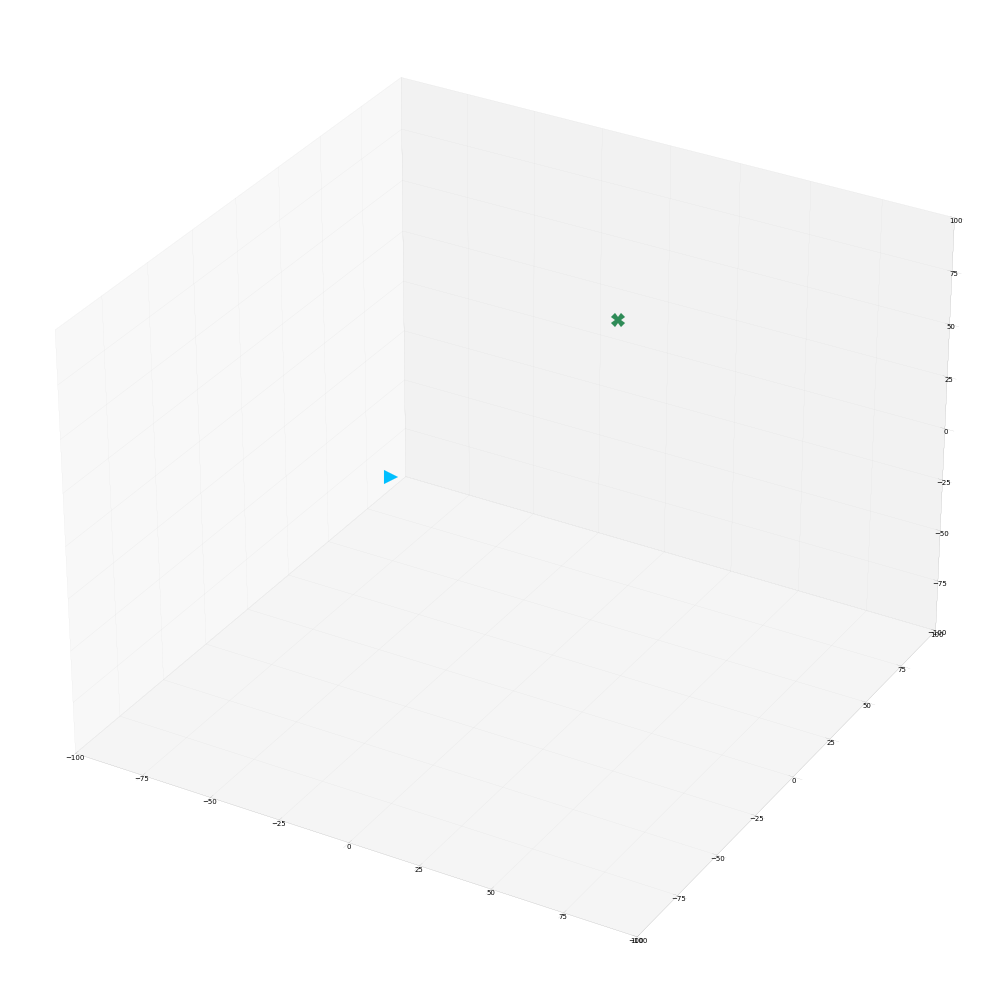

In [5]:
from rddlrepository.archive.competitions.IPPC2023.UAV.UAVsViz import UAVsVisualizer
from pyRDDLGym.core.visualizer.movie import MovieGenerator
problem_info = manager.get_problem("UAV_ippc2023")



domain_factory = lambda alg_name=None: RDDLDomain(rddl_domain=problem_info.get_domain(),
                                                  rddl_instance=problem_info.get_instance(1),
                                                  visualizer=UAVsVisualizer,
                                                  movie_name='UAV-ippc2023-' + alg_name if alg_name is not None else None)
domain = domain_factory()
domain.reset()
domain.render()

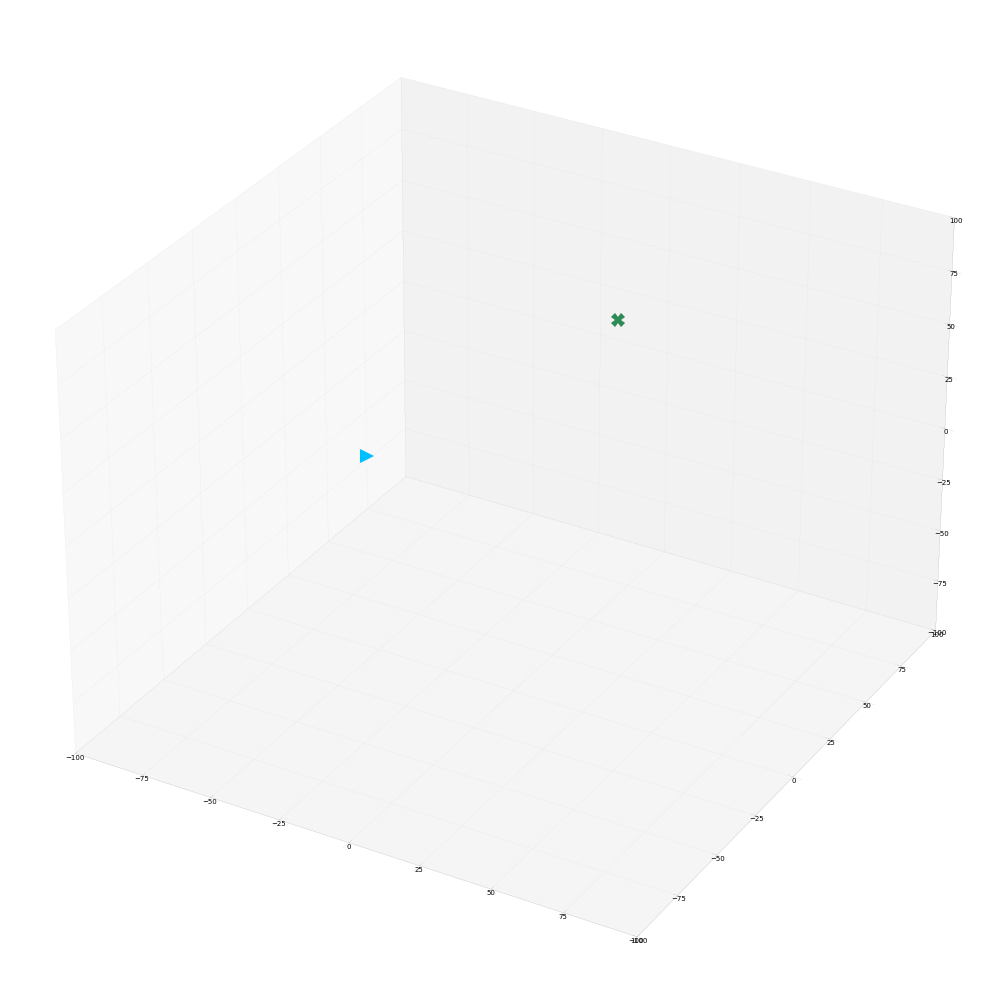

In [19]:
from skdecide.hub.solver.ray_rllib import RayRLlib
from ray.rllib.algorithms.ppo import PPO

solver_factory = lambda: RayRLlib(
    domain_factory=domain_factory, algo_class=PPO, train_iterations=1
)

with solver_factory() as solver:
    solver.solve()
    rollout(
        domain_factory(alg_name='PPO'),
        solver,
        max_steps=100,
        render=True
    )

In [20]:
from skdecide.hub.space.gym import GymSpace
from gymnasium.spaces.utils import flatten_space, flatten
import numpy as np

class RDDLDomainSimplifiedSpaces(RDDLDomain):

    def __init__(self,
                 rddl_domain: str,
                 rddl_instance: str,
                 visualizer: BaseViz = ChartVisualizer,
                 movie_name: str = None,
                 max_frames=100):
        super().__init__(rddl_domain, rddl_instance, visualizer, movie_name, max_frames)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        outcome = super()._state_step(action)
        return TransitionOutcome(
            state=flatten(self.rddl_gym_env.observation_space, outcome.state), value=outcome.value, termination=outcome.termination
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        return GymSpace(flatten_space(self.rddl_gym_env.action_space))

    def _state_reset(self) -> D.T_state:
        # SkDecide only needs the state, not the info
        return flatten(self.rddl_gym_env.observation_space, super()._state_reset())

    def _get_observation_space_(self) -> Space[D.T_observation]:
        return GymSpace(flatten_space(self.rddl_gym_env.observation_space))

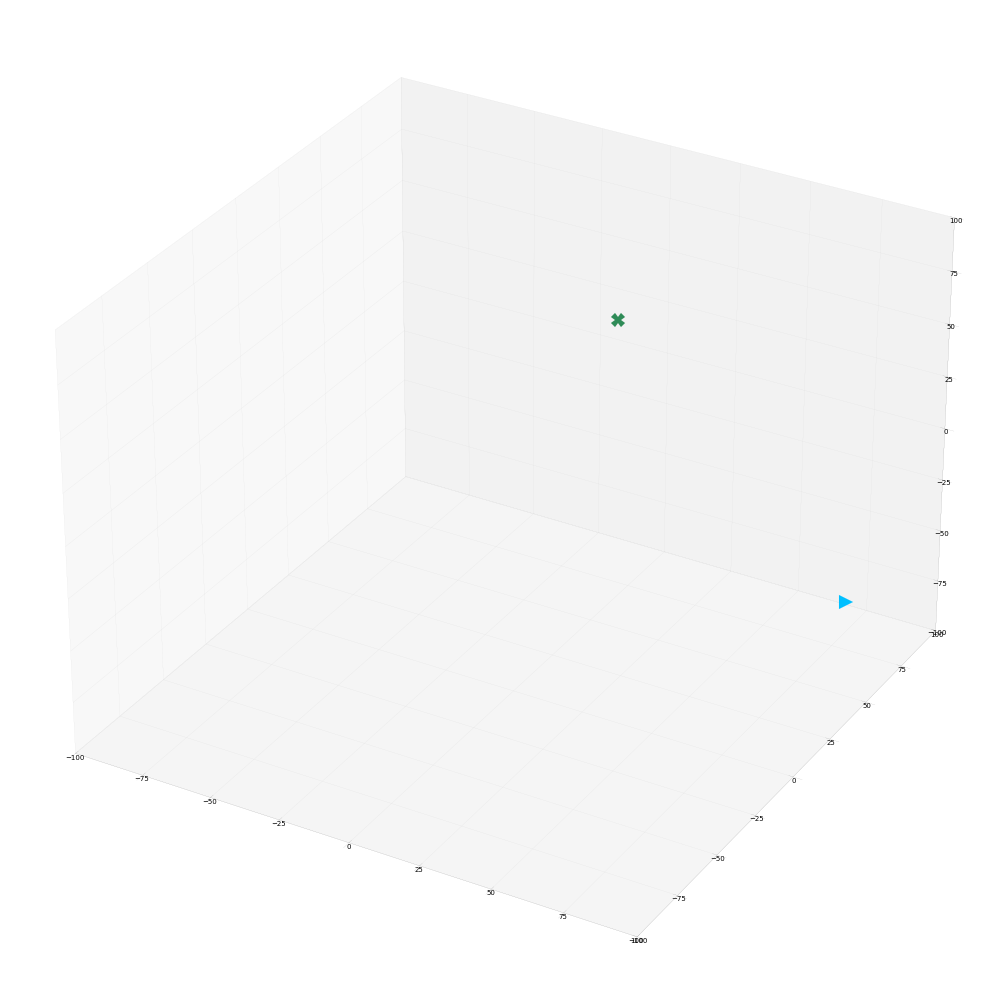

In [21]:
from skdecide.hub.solver.cgp import CGP

domain_factory = lambda alg_name=None: RDDLDomainSimplifiedSpaces(rddl_domain=problem_info.get_domain(),
                                                                  rddl_instance=problem_info.get_instance(1),
                                                                  visualizer=UAVsVisualizer,
                                                                  movie_name='UAV-ippc2023-' + alg_name if alg_name is not None else None)

domain = domain_factory()
            
# assert CGP.check_domain(domain)
solver_factory = lambda: CGP(
    domain_factory=domain_factory, folder_name="TEMP_CGP", n_it=100, verbose=False
)
with solver_factory() as solver:
    solver.solve()
    rollout(
        domain_factory('CGP'),
        solver,
        max_steps=500,
        render=True
    )